Many prediction and regression schemes involve fitting models of the form 
$$
\hat f(x) = \sum_{i=1}^N \hat{a}(\theta_i)\phi(x;\theta_i)
$$

where $\phi(x;\theta)$ is some function of $x\in X$ depending on a parameter $\theta\in\Theta$, and $\hat a(\theta_i)\in \R$. For example, neural networks and SVMs can both be expressed in this form. A natural way to view this strategy is as an approximation via a finite sum to an integral.

$$
f(x) = \int_\Theta a(\theta) \phi(x;\theta)\ d\theta.
$$

The process of choosing values for $N$ and $\theta_i$ vary from model to model. In Neural Networks, $N$ is fixed by the person constructing the model, while for an SVM $N$ is the number of support vectors. In Neural Networks, the $\hat{a}(\theta_i)$ and $\theta_i$ are chosen by maximizing some (generally non-convex) objective function via gradient descent. In SVMs, the $\theta_i$ are set by the data and the $a_i$ are chosen to maximize a (generally convex) objective function. In some instances (e.g. <a href=http://compneuro.uwaterloo.ca/research/nef.html>NEF</a>), the $\theta_i$ are chosen <i>randomly</i> and the $a_i$ are then set by maximizing an objective function. The plan here is to set up a principled way to choose the $\theta_i$ in a randomized fashion with accompanying error bounds.

Choosing $\theta_i$ randomly enjoys extremely fast optimization times since very little work is performed in picking the $\theta_i$ and the optimization of the $\hat{a}(\theta_i)$ is now much easier (generally convex, and in the case of least-squares regression even has a closed-form solution). However it's not so clear that this randomization doesn't cost us a lot in terms of accuracy. To get a bound on how much accuracy we lose by choosing each $\theta_i$ randomly, we can look at <a href=http://pages.cs.wisc.edu/~brecht/papers/08.Rah.Rec.Allerton.pdf>this paper</a> of Rahimi and Recht, which provides a nice bound. We'll briefly sketch their result. Suppose we choose each $\theta_i$ independently from some distribution $p(\theta)$. Let $\|f\|_p= \sup_{\theta}\frac{|a(\theta)|}{p(\theta)}$. Suppose $\|f\|_p\le \infty$. Also suppose $|\phi(x;\theta)|\le 1$ for all $x,\theta$. Finally suppose we are interested in minimizing the expectation $\E_x[(\hat f(x) - f(x))^2]$ with respect to some given probability measure on the inputs $x$. Then with probability $1-\delta$ there is a choice of $\hat{a}(\theta_i)$ such that
$$
\E_x[(\hat f(x) - f(x))^2] < \frac{\|f\|_p}{\sqrt{N}}\left(1+\sqrt{2\log\frac{1}{\delta}}\right).
$$

The proof follows from <a href=https://en.wikipedia.org/wiki/Doob_martingale#McDiarmid.27s_inequality>McDiarmid's inequality</a> and using $\hat{a}(\theta_i) = \frac{a(\theta_i)}{p(\theta_i)N}$; effectively we are employing <a href=https://en.wikipedia.org/wiki/Importance_sampling>importance sampling</a> to approximate $f(x)$. 

This is a very interesting statement - as long as our sampling distribution $p(\theta)$ is reasonably compatible with the function $f$, we will do pretty well by just randomly picking $\theta_i$ - we can even pick them independently!

This equation also implies that ideally we would sample $\theta_i$ from some distribution $p(\theta)$ such that $\|f\|_p$ is as small as possible. Thus a fully general approximation scheme would tune $p(\theta)$ to perform better given data about the function of interest $f$. The optimal distribution from this perspective is one such that $p(\theta)\propto |a(\theta)|$. However, it may not be very easy to acquire samples from this distribution. Instead we'll describe a simpler distribution, and then prove a bound on performance using this distribution.

Before describing a proposal for $p(\theta)$, let's examine a slightly different function, $\tilde f(x)$. First, let $\mu$ be a probability measure on inputs $x\in X$. Then define an inner-product
$$
k(\theta,\theta') = \int_X \phi(x;\theta)\phi(x;\theta')\ \mu(dx)
$$

Let
$$
c_\theta = \frac{\int_\Theta a(\bar \theta) k(\theta,\bar\theta)\ d \bar\theta}{\int_\Theta k(\theta,\bar \theta)\ d\bar\theta}
$$

so that $c_\theta$ is the expectation of $a(\bar\theta)$ under the distribution $k_\theta(\bar\theta)\propto k(\theta,\bar\theta)$. Then we set
$$
\tilde f(x) = \int_\Theta c_\theta \phi(x;\theta)\ d\theta.
$$

Our strategy will have two stages. First we will show that under some reasonable smoothness conditions, $\tilde f(x)\approx f(x)$. Then we will provide a way to sample from a $p(\theta)$ with $p(\theta)\propto c_\theta$. These results, together with the theorem of Rahimi and Recht will give a general way to approximate $f$.

Intuitively, one expects $\tilde f$ to approximate $f$ because when the functions $\phi(x;\theta)$ are very different for different $\theta$ values, we have $c_\theta\approx a(\theta)$.

In the following we formalize this intuition. To make life easier (at least in the long term hopefully), we'll define some more notation:
$$
K_\theta = \int_\Theta k(\theta,\bar\theta)\ d\bar\theta
$$
$$
k_\theta(\bar\theta) = \frac{k(\theta,\bar\theta)}{K_\theta}
$$
so that
$$
\int_\Theta k_\theta(\bar\theta)\ d\bar\theta = 1
$$
$$
c_\theta = \int_\Theta a(\bar \theta) k_\theta(\bar\theta)\ d\theta
$$
And we also make a couple of assumptions:

<ol>
<li>
We'll quantify how fast $k_\theta(\bar\theta)$ falls off (in particular, we assume that it does in fact fall off):
$$
\int_\Theta |\theta-\bar\theta| k_\theta(\bar\theta)\ d\bar\theta = M_\theta
$$
$$
\sup_\Theta M_\theta = M_\sup
$$
</li>
<li>
Also, we will assume that $a(\theta)$ is <a href=https://en.wikipedia.org/wiki/Lipschitz_continuity>Lipschitz continuous</a>:
$$
|a(\theta)-a(\theta')|\le L_a |\theta-\theta'|
$$
</li>
</ol>

These two assumptions capture a few important pieces of intuition:
<OL>
<LI> We are assuming that the $\theta$ values that are close together produce $\phi(x;\theta)$ functions that are similar (i.e. are correlated) and $\theta$ values that are far apart produce $\phi(x;\theta)$ functions that are dissimilar.
<LI> Since nearby $\theta$ values produce similar basis functions $\phi(x;\theta)$, we should expect the weightings $a(\theta)$ to be close to each other.
</OL>

We also define $|\phi|^2$ as
$$
|\phi|^2 = \int_X\left(\int_\Theta |\phi(x;\theta)|\ d\theta\right)^2\ \mu(dx)
$$

With these assumption we can show a useful fact:

Define $\epsilon_\theta =a(\theta)-c_\theta = \int_\Theta \left(a(\theta)-a(\bar\theta)\right)k_\theta(\bar\theta)\ d\bar\theta$. We have
$$
|\epsilon_\theta | = \left|\int_\Theta \left(a(\theta)-a(\bar\theta)\right)k_\theta(\bar\theta)\ d\bar\theta\right| \le\int_\Theta |k_\theta(\bar\theta)(\theta-\bar\theta)L_a|\ d\bar\theta \le M_\theta L_a
$$

Now we put this all together to see that:
$$
\begin{align}
\int_X (\tilde f(x) - f(x))^2\ \mu(dx)&=\int_X\left(\int_\Theta (c_\theta-a(\theta)) \phi(x;\theta)\ d\theta\right)^2\ \mu(dx)\\
&\le\int_X \left(\int_\Theta M_\theta L_\alpha |\phi(x;\theta)|\ d\theta\right)^2 \mu(dx)\\
&\le M_\sup^2L_a^2|\phi|^2
\end{align}
$$

So this shows that when we use $c_\theta$ in place of $a(\theta)$ we might expect not to lose that much. However this doesn't immediately help - we don't actually know what $c_\theta$ is either!

Fortunately, $c_\theta$ turns out to be much easier to estimate:
$$
\begin{align}
c_\theta &= \frac{\int_\Theta a(\bar \theta) k(\theta,\bar\theta)\ d \bar\theta}{\int_\Theta k(\theta,\bar \theta)\ d\bar\theta}\\ 
&= \frac{\int_\Theta\int_X \phi(x;\theta)\phi(x;\bar\theta)a(\bar\theta)\ \mu(dx)\, d\bar\theta}{\int_\Theta k(\theta,\bar \theta)\ d\bar\theta}\\
&=\frac{\int_X \phi(x;\theta) f(x)\ \mu(dx)}{\int_\Theta k(\theta,\bar \theta)\ d\bar\theta}\\
&=\frac{\E_X[ \phi(x;\theta) f(x)]}{\E_X[\int_\Theta \phi(x;\theta)\phi(x;\bar\theta)\ d\bar\theta]}
\end{align}
$$
Given the ability to draw independent samples $(x,f(x))$ with $x$ distributed according to $\mu$, the above allows us to estimate $c_\theta$ using Monte-Carlo integration.

Since we know how to estimate $c_\theta$, we can sample from a distribution $p(\theta)\propto |c_\theta|$ by various methods. One could use MCMC for this, but in the following we'll just compute $c_\theta$ for a large number of $\theta$ values and choose from the resulting discrete distribution over the chosen values.

In case you don't feel like reading through the code (imagine that), I'll summarize the highlights here.

In general we were looking for a function $\hat f(x) = \sum_{i=1}^N \hat a(\theta_i)\phi(x;\theta_i)$ that minimizes
$$
J = \frac{1}{2}\E_x[(\hat f(x)-f(x))^2] + \frac{\lambda}{2}\sum_{i=1}^N \hat a(\theta_i)^2
$$

I used two schemes:

<ol>
<li> randomly choosing $N$ fixed basis functions $\phi(x;\theta_1),\dots,\phi(x;\theta_N)$ and optimizing weights $\hat a(\theta_i)$ in order to minimize $J$. Let's call this a "fixed basis" scheme.</li>
<li> using the BFGS algorithm to optimize both $\theta_i$ and $\hat a(\theta_i)$
</ol>

I set $\phi(x;\theta)=\max(0,\theta\cdot x)$ (rectified linear units). The inputs $x$ were uniformly distributed in $[-1,1]^{10}$. To pick the function $f$, I chose $1000$ random $\theta$ values (also uniformly distributed in $[-1,1]^{10}$ and computed the singular value decomposition of the matrix of values $\phi(x_i,\theta_j)$. $f$ was chosen to be the $10$th singular vector of this decomposition, scaled so that the average value of $f(x)^2$ was 1. The motivation behind this is that the singular vectors should represent in some sense a sequence of "increasingly hard" functions to approximate. This is because adding a little bit of $L_2$ regularization causes greater RMSE on vectors with lower singular values.

Now for each of the two schemes above, I used "non-adaptive" and "adaptive" $\theta$ values. For scheme 1 (fixed basis), "non-adaptive" means that the $\theta_i$ are drawn from the same distribution that the $1000$ $\theta$ values used to choose $f$ were drawn from. "Adaptive" means of course that they are chosen according to $c_\theta$. For scheme 2, the chosen $\theta$ values were used to initialize the BFGS algorithm.

I computed (via trial-and-error basically; the code for this is not shown) values of $N$ for which the fixed-basis function schemes achieves a $J$ value of $0.0003125$ ($2.5\%$ RMSE). The values are shown below:
$$
\begin{array}{c|cc}
N,\text{ RMSE, time}&\text{Fixed Basis Functions}&\ \text{BFGS}\\
\hline
\text{non-adaptive}&10000,\ 0.026,\ 22\text{ seconds }&\ 1000,\ 0.033,\ 1440\text{ seconds }\\
\text{adaptive}&7000,\ 0.025,\ 24\text{ seconds }&\ 1000,\ 0.033,\ 1264\text{ seconds }
\end{array}
$$

So one can see that using adaptive choices provides a significant reduction in number of basis functions required when we are not allowed to optimize the basis functions themselves. I didn't run the full BFGS optimization at a high enough number of basis vectors to achieve comporable error because I got too impatient. This highlights the point that the random methods are significantly faster than using a more complicated optimization proceedure. However, the BFGS optimization should be expected to achieve significant savings in terms of number of basis functions used even if it takes much longer to train.

In fact, if we are satisfied with an RMSE of $0.05$ rather than $0.025$, then by optimizing the basis functions using BFGS we only need roughly $175$ basis functions while using the adaptively chosen random basis functions we need about $1200$, and $2000$ for the non-adaptive random method. As a further caveat, if we increase the difficulty of the problem by increasing the index of the singular value used to choose the function $f$ the number of basis functions needed to achieve low error increases very quickly, and the advantage accrued by using the adaptive method becomes less obvious. On the other hand, the cost in terms of time for doing the adaptive method is relatively small and so perhaps this is not such a big deal.

Ok time for the code. Let's set up some framework for computing the output of a neural net with rectified linear activation functions.

In [1]:
# <!-- collapse=True -->
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import scipy.stats
from copy import copy
import time
%matplotlib inline

In [30]:
# <!-- collapse=False -->
def relu(x):
    return np.maximum(0,x)

def reluprime(x):
    return np.clip(np.sign(x),0,1)

def EvalModel(X,E,W,tuning = relu):
    return np.dot(W,tuning(np.dot(E,np.transpose(X))))

def num_derivative(f,x,epsilon=0.000001):
    fx = f(x)
    xi = copy(x)
    g = np.zeros(len(x))
    for i in xrange(len(x)):
        xi[i] += epsilon
        g[i] = (f(xi)-f(x))/epsilon
        xi[i] -= epsilon
    return g

def ReluDerivative(X,Z,E,W):
    """This function implements the chain rule (also called backprop)"""
    Egrad = np.zeros(np.shape(E))
    Wgrad = np.zeros(np.shape(W))
    errs = EvalModel(X,E,W,relu)-Z
    transdot = np.dot(E,np.transpose(X))
    Wgrad = np.sum(errs*relu(transdot),axis = 1)
    errfp = np.transpose(np.dot(np.transpose(X),W*np.transpose(errs*reluprime(transdot))))
    return errfp/len(X),Wgrad/len(X)

def ReluObjective(X,Z,E,W):
    err = np.linalg.norm(EvalModel(X,E,W,relu)-Z)**2
    return err*0.5/len(X)

def RandEnc(n,d):
    return np.random.uniform(-1,1,(n,d))

def RunPackedRelu(x,P,n):
    d = len(x)
    E = np.reshape(P[:n*d],(n,d))
    W = P[n*d:]
    return EvalModel(x,E,W,relu)

def PackParams(E,W):
    return np.append(E.flatten(),W)

def UnPackParams(P,n,d):
    return np.reshape(P[:n*d],(n,d)),P[n*d:]

def GetObjFunc(X,Z,n,d,l=0):
    mask = np.zeros(n*d+n)
    mask[n*d:]= 1.0
    return lambda P: ReluObjective(X,Z,*UnPackParams(P,n,d))+l/2.0*np.linalg.norm(P*mask)**2

def GetDerFunc(X,Z,n,d,l=0):
    mask = np.zeros(n*d+n)
    mask[n*d:]= 1.0
    return lambda P: PackParams(*ReluDerivative(X,Z,*UnPackParams(P,n,d)))+l*P*mask

def GetDecObjFunc(X,Z,E,n,d,l=0):
    return lambda P: ReluObjective(X,Z,E,P)+l/2.0*np.linalg.norm(P)**2

def GetDecDerFunc(X,Z,E,n,d,l=0):
    return lambda P: ReluDerivative(X,Z,E,P)[1]+l*P

def TestDer():
    n = 10
    d = 5
    p = 3
    E = RandEnc(n,d)
    W = np.random.uniform(-1,1,n)
    x = np.random.uniform(-1,1,(p,d))
    z = [np.random.uniform(-1,1) for i in range(p)]
    obj = GetObjFunc(x,z,n,d,0.2) #objective function
    start = time.clock()
    der = GetDerFunc(x,z,n,d,0.2) #derivative function
    end = time.clock()
    print "Time: ",end-start
    nd = num_derivative(obj,PackParams(E,W)) #numerical derivative
    ad = der(PackParams(E,W)) #analytical derivative
    
    print "numerical to analytical difference: ",np.linalg.norm(nd-ad)/np.linalg.norm(nd)
    
TestDer()

Time:  6.99999873177e-06
numerical to analytical difference:  5.81163073336e-07


Our objective and derivative computation checks out. Now we'll setup a testing scenario. To do this we will first generate a random set of inputs and encoding weights and compute the SVD of the resulting activation function to get a number of functions with varying degrees of easiness to fit. The idea here is that singular vectors with low singular values are harder to fit - intuitively these are functions for which $a(\theta)$ has high magnitude. Then we'll fit the functions with an standard black-box optimization algorithm (BFGS) as well as randomization and see what happens!

In [3]:
# <!-- collapse=False -->
def randomX(p,d):
    return np.random.uniform(-1,1,(p,d))

def randomfuncs(p,d,n):
    E = RandEnc(n,d)
    X = randomX(p,d)
    A = relu(np.dot(E,np.transpose(X)))
    u,s,v = np.linalg.svd(A)
    plt.plot(s)
    plt.yscale('log')
    plt.ylabel('Singular Values')
    plt.show()
    return v*np.sqrt(p),E,X,s #rows of v are eigenvectors of AtA

def fitfunc(X,Z,n,E0=None,l=0):
    d = len(X[0])
    p = len(Z)
    grad = GetDerFunc(X,Z,n,d,l)
    obj = GetObjFunc(X,Z,n,d,l)
    if(E0==None):
        E0 = RandEnc(n,d)
    P0 = PackParams(E0,np.random.normal(0,0.1,n)) #initial guess
    bounds = tuple([(-1,1) for i in xrange(n*d)]+[(None,None) for i in xrange(n)])
    
    opt = scipy.optimize.fmin_l_bfgs_b(func = obj,x0 = P0,fprime = grad,disp = -1, bounds = bounds)
    xopt = opt[0]
    fopt = obj(xopt)
    return fopt


def decode(X,Z,E,l=0.0):
    """computes a linear decode given inputs X,
        targets Z, theta values in E, and regularization constant l"""
    n = np.shape(E)[0]
    d = np.shape(E)[1]
    A = relu(np.dot(X,np.transpose(E)))
    opt = scipy.sparse.linalg.lsqr(A,Z,np.sqrt(l*len(Z)/2))
    obj = GetObjFunc(X,Z,n,d,l)
    return obj(PackParams(E,opt[0]))

def getdecode(X,Z,E,l=0.0):
    n = np.shape(E)[0]
    d = np.shape(E)[1]
    A = relu(np.dot(X,np.transpose(E)))
    opt = scipy.sparse.linalg.lsqr(A,Z,np.sqrt(l*len(Z)/2))
    obj = GetObjFunc(X,Z,n,d,l)
    return opt[0]

def getlinearerror(X,Z,l=0.0):
    """computes the error from fitting Z with a linear map Z=WX"""
    opt = scipy.sparse.linalg.lsqr(X,Z,np.sqrt(l*len(Z)/2))
    return np.linalg.norm(np.dot(X,opt[0])-Z)**2/len(Z) + l/2.0*np.linalg.norm(opt[0])**2

def Ctheta(theta,X,Z,tsamples = 1000,A=None,xsamples=None):
    """computes Ctheta distribution using tsamples"""
    d = np.shape(X)[1]
    p = len(Z)
    if(xsamples == None):
        xsamples = np.arange(len(X))
    phitheta = relu(np.dot(X[xsamples],theta))
    numerator = np.dot(phitheta,Z[xsamples])
    
    if(A == None):
        Es = RandEnc(tsamples,d)
        A = relu(np.dot(E,np.transpose(X))) #d by n

    denominator =  np.sum(np.dot(A,phitheta)/samples)
    
    return numerator/denominator

def getsamples(dist,N):
    a = np.linalg.norm(dist,1)
    p = np.abs(dist)/a
    sampler = scipy.stats.rv_discrete(values=(range(len(dist)), p))
    return sampler.rvs(size = N)


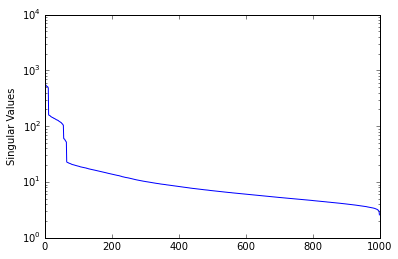

In [4]:
# <!-- collapse=False -->
d = 10
p = 10000

v,Ev,X,s = randomfuncs(p,d,1000)

Now we've got a list of functions stored in the matrix $v$. We'll use the $10^{th}$ singular vector to run our approximations. I've experimented around already to find numbers of basis functions to use that put the non-BFGS methods at an RMSE of nearly $0.025$. The function we're fitting will be normalized so that predicting zero at all points achieves an RMSE of $1.0$.

In [5]:
# <!-- collapse=False -->
samples = 100000
approxsamples = 100
hardness = 10
E = RandEnc(samples,d)


start_theta = time.clock()
xsamples = np.random.choice(np.arange(p),approxsamples)
A = relu(np.dot(RandEnc(approxsamples,d),np.transpose(X[xsamples])))
Cthetas = [Ctheta(theta,X,v[hardness],approxsamples,A=A,xsamples = xsamples) for theta in E]
end_theta = time.clock()

print "Got Ctheta values"
print "Time: ",end_theta-start_theta


Got Ctheta values
Time:  4.480582


In [6]:
# <!-- collapse=False -->
numada = 7000
numrand = 10000
l=0.1
print "Baseline Error: ",np.sqrt(2*getlinearerror(X,v[hardness],0))

rtime = 0
ropt = 0
numi = 10
for i in range(numi):
    indices = getsamples(np.ones(len(E)),numrand)
    E0 = RandEnc(numrand,d)#E[indices]
    start = time.clock()
    opt = decode(X,v[hardness],E0,l)
    end= time.clock()
    rtime += (end-start)/float(numi)
    ropt += opt/numi
print "Randomized Start decode error: ",np.sqrt(2*ropt)
print "Time: ",rtime

atime = 0
aopt = 0
for i in range(numi):
    indices = getsamples(Cthetas,numada)
    E0 = E[indices]
    start = time.clock()
    opt = decode(X,v[hardness],E0,l)
    end= time.clock()
    atime += (end-start)/float(numi)
    aopt += opt/numi

print "Adaptive Start decode error: ",np.sqrt(2*aopt)
print "Time: ",atime

print "Total Adaptive Time: ",atime+end_theta-start_theta

Baseline Error:  0.119956800611
Randomized Start decode error:  0.0261701919643
Time:  22.2514216
Adaptive Start decode error:  0.025090050377
Time:  19.2620488
Total Adaptive Time:  23.7426308


In [7]:
# <!-- collapse=False -->
numbfgs = 1000
rbtime = 0
rbopt = 0
for i in range(numi):
    indices = getsamples(np.ones(len(E)),numbfgs)
    E0 = RandEnc(numbfgs,d)#E[indices]
    start = time.clock()
    opt = fitfunc(X,v[hardness],numbfgs,E0=E0,l=l)
    end = time.clock()
    rbtime += (end-start)/numi
    rbopt += opt/numi
print "Random Start BFGS Error: ",np.sqrt(2*rbopt)
print "Time: ",rbtime

Random Start BFGS Error:  0.0333144119113
Time:  1440.8773858


In [8]:
# <!-- collapse=False -->
numbfgs = 1000
abtime = 0
abopt = 0
for i in range(numi):
    indices = getsamples(Cthetas,numbfgs)
    E0 = E[indices]
    start = time.clock()
    opt = fitfunc(X,v[hardness],numbfgs,E0=E0,l=l)
    end = time.clock()
    abtime += (end-start)/numi
    abopt += opt/numi
print "Adaptive Start BFGS Error: ",np.sqrt(2*abopt)
print "Time: ",abtime
print "Total Adaptive BFGS Time: ",abtime +end_theta-start_theta

Adaptive Start BFGS Error:  0.0339679040565
Time:  1260.1757173
Total Adaptive BFGS Time:  1264.6562993
